# Импорты

In [49]:
import sys
print(sys.version)

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]


In [76]:
# Импорты
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# ГИПЕРПАРАМЕТРЫ

In [92]:
# ГИПЕРПАРАМЕТРЫ И КОНСТАНТЫ
RANDOM_SEED = 43  # фиксированное число рандома
SEQ_LENGTH = 3  # длина последовательности
HIDDEN_SIZE = 64 # Размерность вектора каждого входа модели
NUM_LAYERS = 3 # количество слоев нейросети
N_SPLITS = 5  # количество блоков для кросс-валидации
NUM_EPOCHS = 16  # количество эпох обучения 
BATCH_SIZE = 64  # размер батча
LEARNING_RATE = 0.001  # ленинг рейт)

In [94]:
# задаем фиксированные рандомы
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Загрузка данных

В качестве датасета выступает набор данных Московского региона, целевой переменной разница температур фоновых станций и метеостанции Балчуг.
В данном примере тестовой выборкой является июнь 2021 года, а в тренировочной выборкой все остальные данные.
Модель, основанная на рекуррентной нейросети LSTM, попробует аппроксимировать разницу температур на основе крупномасштабных гидрометеорологических параметров.

In [57]:
# Загрузка данных
df = pd.read_csv('D:/RSHU_LIMA_VARENTSOV_2025/data/Moscow_basic.csv', sep=';', index_col=0, parse_dates=[0])
df = df.drop(['delta_t2m_id27416', 'delta_t2m_id27612', 'delta_t2m_id27617'], axis=1)

columns_to_drop = [col for col in df.columns if col.startswith('rur')]     # оставляем данные реанализа
df = df.drop(columns_to_drop, axis=1)

df_test = df.loc['2021-06-01 00:00:00':'2021-06-30 21:00:00'] # июнь 2021 г
df_main = df.drop(df_test.index) # остальной набор данных

# Обучаем модель

In [64]:
def create_seq_with_indices(df, features, target, seq_len):
    n = len(df)
    indices = np.arange(seq_len) + np.arange(0, n - seq_len + 1)[:, np.newaxis]  # Shape: (n_seq, seq_len)

    X_data = df[features].values.astype(np.float32)
    y_data = df[target].values.astype(np.float32)

    X_seq = X_data[indices]  # Shape: (n_sequences, seq_len, n_features)
    y_seq = y_data[seq_len - 1:]  # First target at index SEQ_LENGTH - 1

    # Сохраняем индексы целевых значений в исходном датафрейме
    target_indices = np.arange(seq_len - 1, n)  # Индексы целевых значений
    
    return X_seq, y_seq, target_indices

train_data = df_main.copy()
test_data = df_test.copy()

# Выделение признаков и целевой переменной
features = train_data.columns.drop('delta_t2m_id27605')
target = 'delta_t2m_id27605'

X_tr, y_tr, train_indices = create_seq_with_indices(train_data, features, target, SEQ_LENGTH)
X_te, y_te, test_indices = create_seq_with_indices(test_data, features, target, SEQ_LENGTH)


"""
Подробно разберем пример с разделением на последовательности:
Пусть SEQ_LENGTH = 3 и у нас блок с 10 точками:

Индексы:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Данные:   [A, B, C, D, E, F, G, H, I, J]

Цикл начинается с i = 2 (SEQ_LENGTH - 1):

Итерация 1 (i = 2):
X_block[2-3+1:2+1] = X_block[0:3] = [A, B, C]
y_block[2] = C

Логика: Используем точки [0,1,2] чтобы предсказать точку 2

Итерация 2 (i = 3):
X_block[3-3+1:3+1] = X_block[1:4] = [B, C, D]
y_block[3] = D

Логика: Используем точки [1,2,3] чтобы предсказать точку 3

Итерация 3 (i = 4):
X_block[4-3+1:4+1] = X_block[2:5] = [C, D, E]
y_block[4] = E
И так далее...

Последняя итерация (i = 9):
X_block[9-3+1:9+1] = X_block[7:10] = [H, I, J]
y_block[9] = J
"""
def filter_nan_sequences_with_indices(X, y, indices):
    """Удаляет последовательности с NaN и сохраняет исходные индексы"""
    mask = (~np.isnan(X).any(axis=(1, 2))) & (~np.isnan(y))
    
    X_filtered = X[mask]
    y_filtered = y[mask]
    indices_filtered = indices[mask]  # Сохраняем индексы тестового набора (уже без nan)
    
    return X_filtered, y_filtered, indices_filtered

# Фильтруем с сохранением индексов
X_train, y_train, train_filtered_indices = filter_nan_sequences_with_indices(X_tr, y_tr, train_indices)
X_test, y_test, test_filtered_indices = filter_nan_sequences_with_indices(X_te, y_te, test_indices)

# Определение модели LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.regressor(out[:, -1, :]).squeeze()

# Нормализация данных
scaler_X = StandardScaler().fit(X_train.reshape(-1, X_train.shape[2]))
scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))

X_train_scaled = scaler_X.transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1)).flatten()

# Создание DataLoader
train_dataset = TensorDataset(torch.tensor(X_train_scaled), torch.tensor(y_train_scaled))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Обучение модели
model = LSTMModel(input_size=X_train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = torch.sqrt(nn.MSELoss()(outputs, batch_y))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

# Предсказание на тестовых данных
model.eval()
with torch.no_grad():
    test_preds_scaled = model(torch.tensor(X_test_scaled)).numpy()

# Обратное преобразование нормализации
y_pred_LSTM = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()

In [65]:
# Создаем датафрейм с ВСЕМИ датами тестового набора
full_results = pd.DataFrame(index=test_data.index)  # Все даты тестового периода
full_results['true'] = test_data[target]  # Все исходные значения

# Получаем даты для валидных индексов
valid_dates = test_data.index[test_filtered_indices]

# Создаем временный датафрейм с pred для валидных индексов
pred_df = pd.DataFrame({
    'predicted': y_pred_LSTM
}, index=valid_dates)  # Используем сохраненные индексы

# Объединяем: предсказания попадут только на те индексы, где были валидные данные
full_results['predicted'] = pred_df['predicted']

In [66]:
# Добавляем флаг, были ли данные валидными
full_results['is_valid'] = (~full_results['true'].isna()) & (~full_results['predicted'].isna())

# Вычисляем метрики только для валидных точек
valid_mask = full_results['is_valid']
rmse = np.sqrt(mean_squared_error(
    full_results.loc[valid_mask, 'true'], 
    full_results.loc[valid_mask, 'predicted']
))
r2 = r2_score(
    full_results.loc[valid_mask, 'true'], 
    full_results.loc[valid_mask, 'predicted']
)

print(f"\nМетрики на валидных данных:")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")


Метрики на валидных данных:
Test RMSE: 1.0369
Test R²: 0.7923


In [84]:
full_results

,true,predicted,is_valid
time,,,
2021-06-01 00:00:00,6.06,NaN,False
2021-06-01 03:00:00,5.91,NaN,False
2021-06-01 06:00:00,0.90,1.214482,True
2021-06-01 09:00:00,0.81,0.873680,True
2021-06-01 12:00:00,1.04,0.973441,True
...,...,...,...
2021-06-30 09:00:00,0.01,0.936517,True
2021-06-30 12:00:00,2.22,0.967632,True
2021-06-30 15:00:00,1.20,0.941578,True


# Анализ результатов

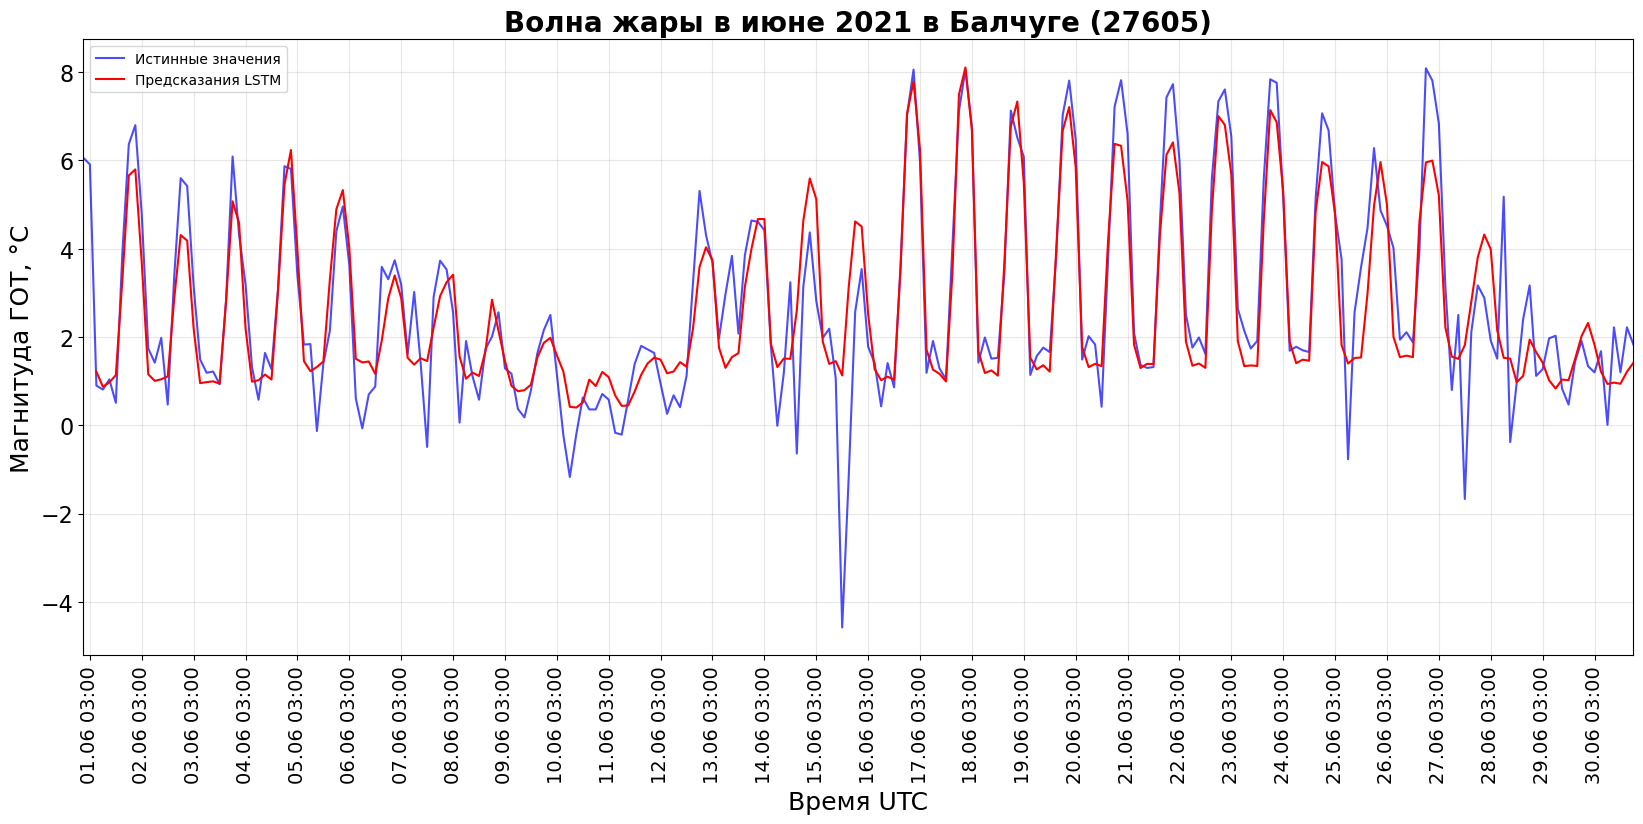

In [90]:
plt.figure(figsize=(20, 8))
plt.plot(full_results.index, full_results['true'], 'b-', label='Истинные значения', alpha=0.7)
plt.plot(full_results.index, full_results['predicted'], 'r-', label='Предсказания LSTM', markersize=4)
plt.ylabel('Магнитуда ГОТ, °C', fontsize=18, labelpad=5)
plt.xlabel('Время UTC', fontsize=18, labelpad=5)
plt.title('Волна жары в июне 2021 в Балчуге (27605)', fontsize=20, fontweight='bold')
plt.legend()
plt.xlim(full_results.index[0], full_results.index[-1])
plt.xticks(fontsize=14, rotation=90, ha='center')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.3)
plt.show()

# КРОСС-ВАЛИДАЦИЯ

# ГРУЗИМ ДАННЫЕ

In [104]:
# Загрузка данных
data = pd.read_csv('D:/RSHU_LIMA_VARENTSOV_2025/data/Moscow_basic.csv', sep=';', index_col=0, parse_dates=[0])
data = data.drop(['delta_t2m_id27416', 'delta_t2m_id27612', 'delta_t2m_id27617'], axis=1)

columns_to_drop = [col for col in data.columns if col.startswith('rur')]     # оставляем данные реанализа
data = data.drop(columns_to_drop, axis=1)

# Выделение целевой переменной и признаков
features = data.columns.drop('delta_t2m_id27605')
target = 'delta_t2m_id27605'

print(data.columns)

Index(['delta_t2m_id27605', 'ERA5_t2m', 'ERA5_ps', 'ERA5_u10m', 'ERA5_v10m',
       'ERA5_tcc', 'ERA5_lcc', 'ERA5_blh', 'ERA5_str', 'ERA5_ssr', 'ERA5_ssrd',
       'ERA5_strd', 'ERA5_vel10m', 'ERA5_dir10', 'ERA5_tp_3h', 'ERA5_rh2m'],
      dtype='object')


In [106]:
# ФУНКЦИИ
def create_seq_with_indices(df, features, target, seq_len):
    """Создает последовательности и возвращает индексы целевых значений"""
    n = len(df)
    indices = np.arange(seq_len) + np.arange(0, n - seq_len + 1)[:, np.newaxis]
    
    X_data = df[features].values.astype(np.float32)
    y_data = df[target].values.astype(np.float32)
    
    X_seq = X_data[indices]
    y_seq = y_data[seq_len - 1:]
    target_indices = np.arange(seq_len - 1, n)
    
    return X_seq, y_seq, target_indices

def filter_nan_sequences_with_indices(X, y, indices):
    """Удаляет последовательности с NaN и сохраняет исходные индексы"""
    mask = (~np.isnan(X).any(axis=(1, 2))) & (~np.isnan(y))
    
    X_filtered = X[mask]
    y_filtered = y[mask]
    indices_filtered = indices[mask]
    
    return X_filtered, y_filtered, indices_filtered

In [108]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score

# Определение модели LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.regressor(out[:, -1, :]).squeeze()

# Основной код кросс-валидации
BLOCK_SIZE = len(data) // N_SPLITS

# Формирование блоков для кросс-валидации
all_blocks_data = []

for block_idx in range(N_SPLITS):
    # Определяем границы блока во всем датасете
    start_idx = block_idx * BLOCK_SIZE
    end_idx = (block_idx + 1) * BLOCK_SIZE if block_idx < N_SPLITS - 1 else len(data)
    
    # Вырезаем блок данных
    block_data = data.iloc[start_idx:end_idx]
    
    # Создаем последовательности из блока
    X_block, y_block, block_indices = create_seq_with_indices(block_data, features, target, SEQ_LENGTH)
    
    # Удаляем последовательности с NaN значениями
    X_filtered, y_filtered, indices_filtered = filter_nan_sequences_with_indices(X_block, y_block, block_indices)
    
    indices_absolute = indices_filtered + start_idx  # Преобразуем локальные индексы блока в абсолютные индексы датафрейма loc+abs
    
    all_blocks_data.append({
    'X': X_filtered,           # Признаки последовательностей без NaN
    'y': y_filtered,           # Целевые значения соответствующих последовательностей
    'indices': indices_absolute,  # Абсолютные индексы в исходном датафрейме
    'block_id': block_idx      # Идентификатор блока для групповой кросс-валидации
    })

# Создаем массивы для всех блоков
all_X = np.concatenate([block['X'] for block in all_blocks_data])
all_y = np.concatenate([block['y'] for block in all_blocks_data])
all_groups = np.concatenate([[block['block_id']] * len(block['X']) for block in all_blocks_data])
all_indices = np.concatenate([block['indices'] for block in all_blocks_data])

# Массив для хранения всех прогнозов
full_predictions = np.full(len(data), np.nan)
fold_metrics = []
input_size = all_X.shape[2]

# Кросс-валидация по 5 блокам
group_kfold = GroupKFold(n_splits=N_SPLITS)

for fold, (train_idx, val_idx) in enumerate(group_kfold.split(all_X, all_y, all_groups)):
    # Нормализация данных для текущего фолда
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # Обучение нормализаторов только на тренировочных данных
    X_train_fold = all_X[train_idx]
    X_train_fold_scaled = scaler_X.fit_transform(X_train_fold.reshape(-1, input_size)).reshape(X_train_fold.shape)
    
    y_train_fold = all_y[train_idx]
    y_train_fold_scaled = scaler_y.fit_transform(y_train_fold.reshape(-1, 1)).flatten()
    
    # Преобразование тестовых данных
    X_test_fold = all_X[val_idx]
    y_test_fold = all_y[val_idx]
    
    X_test_fold_scaled = scaler_X.transform(X_test_fold.reshape(-1, input_size)).reshape(X_test_fold.shape)
    y_test_fold_scaled = scaler_y.transform(y_test_fold.reshape(-1, 1)).flatten()
    
    # Создание DataLoader
    train_loader = DataLoader(
        TensorDataset(
            torch.tensor(X_train_fold_scaled), 
            torch.tensor(y_train_fold_scaled)
        ),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    # Обучение модели
    model = LSTMModel(input_size=input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = torch.sqrt(nn.MSELoss()(outputs, batch_y))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
    # Тестирование
    model.eval()
    with torch.no_grad():
        test_preds_scaled = model(torch.tensor(X_test_fold_scaled)).numpy()
    
    # Обратное преобразование прогнозов
    test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
    y_test_true = scaler_y.inverse_transform(y_test_fold_scaled.reshape(-1, 1)).flatten()
    
    # Сохраняем прогнозы для тестовой выборки
    test_indices = all_indices[val_idx]
    for idx, pred in zip(test_indices, test_preds):
        full_predictions[idx] = pred
    
    # Расчет метрик
    rmse = np.sqrt(mean_squared_error(y_test_true, test_preds))
    r2 = r2_score(y_test_true, test_preds)
    fold_metrics.append({'fold': fold + 1, 'rmse': rmse, 'r2': r2})

    print(f"Fold {fold + 1} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Сбор метрик кросс-валидации
cv_scores = {
    'test_r2': [m['r2'] for m in fold_metrics],
    'test_rmse': [m['rmse'] for m in fold_metrics]
}

# Вывод результатов кросс-валидации
print(f"R²: {np.mean(cv_scores['test_r2']):.4f} ± {np.std(cv_scores['test_r2']):.4f}")
print(f"RMSE: {np.mean(cv_scores['test_rmse']):.4f} ± {np.std(cv_scores['test_rmse']):.4f}")

# Создание итогового датафрейма с датами и результатами
cv_results = pd.DataFrame({
    'true': data[target].values,
    'predicted': full_predictions
}, index=data.index)

Fold 1 - RMSE: 0.7515, R²: 0.7843
Fold 2 - RMSE: 0.8260, R²: 0.7803
Fold 3 - RMSE: 0.8089, R²: 0.7738
Fold 4 - RMSE: 0.7606, R²: 0.7713
Fold 5 - RMSE: 0.8112, R²: 0.8053
R²: 0.7830 ± 0.0121
RMSE: 0.7917 ± 0.0298


# Облако точек

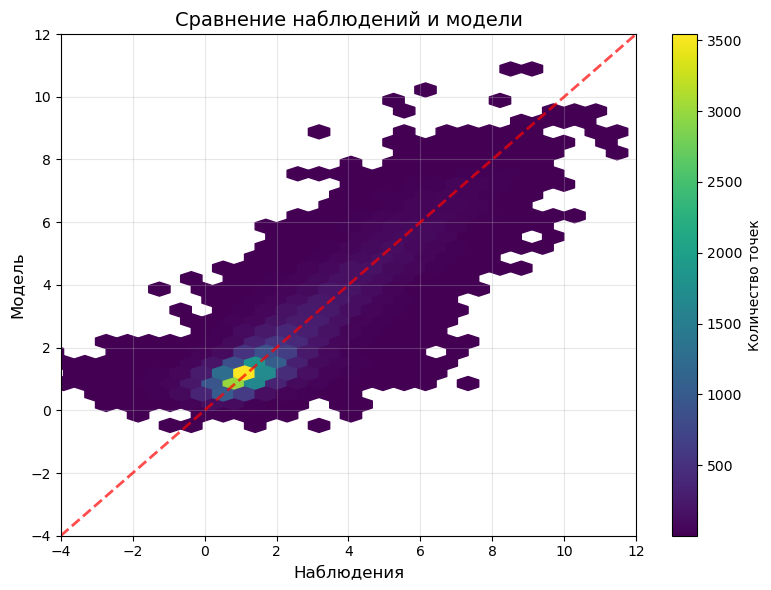

In [122]:
plt.figure(figsize=(8, 6))

# Hexbin plot
plt.hexbin(cv_results['true'], 
           cv_results['predicted'], 
           gridsize=30,
           cmap='viridis',
           mincnt=1)

lims = [-4, 12]
plt.plot(lims, lims, 'r--', alpha=0.7, linewidth=2)

# Настройки графика
plt.xlabel('Наблюдения', fontsize=12)
plt.ylabel('Модель', fontsize=12)
plt.title('Сравнение наблюдений и модели', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xlim(lims)
plt.ylim(lims)

# Цветовая шкала
plt.colorbar(label='Количество точек')

plt.tight_layout()
plt.show()